In [1]:
%matplotlib inline 

In [ ]:
import pandas as pd
import os, cv2, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import json
from PIL import Image
import glob
import shutil
import pathlib
import pickle


In [ ]:
from urllib import request
from zipfile import ZipFile

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils import data

from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

torch.manual_seed(360);

In [4]:
TRAIN_DIR = '../data/processed/'
TRAIN_DIR = '../data/subset/'
CHANNELS = 3

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])   
}


master_ds = datasets.ImageFolder(TRAIN_DIR, data_transforms["train"])
#val_ds = datasets.ImageFolder(valid_dir, data_transforms["valid"])

In [6]:
!ls {TRAIN_DIR}/house_wren | head

005a3a7107e64a0681f9cf681f98e48e.jpg
015d4f33a49541b9b21f77a5b193e4f4.jpg
0460dd1a714d429da0533516cd5b0ed9.jpg
086de7a92d4941f49ee87afb4a3f07be.jpg
0dc364959aae49018ae2d7bf44e4a888.jpg
0e91a80f37ef43638ec1a3a2c003fd57.jpg
13f0bdc0eb264772b2b7c260d92a6bee.jpg
15424421bdef4ca3a4c2c1e08f6697d7.jpg
171b7e117846456d8413d6d5cb955abf.jpg
1970a7c8dfad482bb6707fe5502e791f.jpg


In [7]:
sample_image = f"{TRAIN_DIR}/house_wren/13f0bdc0eb264772b2b7c260d92a6bee.jpg"

In [8]:
im = Image.open(sample_image)

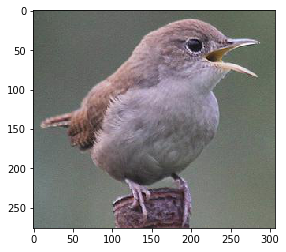

In [9]:
plt.imshow(im)

In [10]:
CLASSES = os.listdir(TRAIN_DIR)
CLASSES[0:5]

['white-winged_dove', 'long-tailed_duck', 'anhinga', 'willet', 'wrentit']

In [11]:
n = len(master_ds)
n_train = int(n*0.80)
n_val = int(n*0.05)
n_test = n - n_train - n_val
num_classes = len(CLASSES)


In [12]:
train_ds, val_ds, test_ds = data.random_split(master_ds, (n_train, n_val, n_test))


In [13]:
train_ds_classes = train_ds.dataset.classes
train_ds_classes

['american_dipper',
 'anhinga',
 'barn_owl',
 'dunlin',
 'hoary_redpoll',
 'house_wren',
 'loggerhead_shrike',
 'long-tailed_duck',
 'mallard',
 'red-eyed_vireo',
 'red-tailed_hawk',
 'snowy_owl',
 'turkey_vulture',
 'white-winged_dove',
 'willet',
 'wrentit']

In [14]:
idx_to_class = {val: key for key, val in    
                                      train_ds.dataset.class_to_idx.items()}

In [15]:
idx_to_class

{0: 'american_dipper',
 1: 'anhinga',
 2: 'barn_owl',
 3: 'dunlin',
 4: 'hoary_redpoll',
 5: 'house_wren',
 6: 'loggerhead_shrike',
 7: 'long-tailed_duck',
 8: 'mallard',
 9: 'red-eyed_vireo',
 10: 'red-tailed_hawk',
 11: 'snowy_owl',
 12: 'turkey_vulture',
 13: 'white-winged_dove',
 14: 'willet',
 15: 'wrentit'}

In [16]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)


In [17]:
from skorch.callbacks import LRScheduler , Freezer , Checkpoint

In [18]:
lrscheduler = LRScheduler(
    policy='StepLR', step_size=7, gamma=0.1)

checkpoint = Checkpoint(
    f_params='best_model.pt', monitor='valid_acc_best')



freezer = Freezer(lambda x: not x.startswith('fc'))

In [19]:
num_workers =3
max_epochs = 25

In [20]:
net = NeuralNetClassifier(
    model_ft, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=32,
    max_epochs=max_epochs,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=num_workers,
    iterator_valid__shuffle=True,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(val_ds),
    #iterator_train = train_ds,
    #iterator_valid = val_ds ,
    callbacks=[lrscheduler, checkpoint],
    device='cuda' # comment to train on cpu
)

In [21]:
net.fit(train_ds,y=None)

  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        2.3419       0.6117        1.5997     +  10.6244
      2        1.4203       0.7864        0.8896     +  9.7369
      3        0.8659       0.8544        0.5920     +  9.8032
      4        0.6535       0.9126        0.3538     +  9.7295
      5        0.5058       0.8932        0.4039        9.7674
      6        0.4293       0.8932        0.3022        9.7680
      7        0.3996       0.8738        0.3810        9.8096
      8        0.3517       0.8835        0.3358        9.7475
      9        0.3539       0.9417        0.2755     +  9.7191
     10        0.3535       0.9223        0.2813        9.7597
     11        0.3661       0.9417        0.2806        9.7442
     12        0.3126       0.9029        0.2728        9.7839
     13        0.3277       0.9029        0.3425        9.7382
     14        0.3251       0.8835        0.3750    

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
    

In [22]:
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(im)

In [23]:
def predict_class(image_path,net):
    img = Image.open(image_path)
    img_tensor = data_transforms["valid"](img).unsqueeze(0)
    
    logits = net.predict_proba(img_tensor)
    probs = torch.softmax(torch.from_numpy(logits),dim=1).detach().numpy().tolist()[0]
    predicted_classes = []
    for c, prob in zip(train_ds_classes,probs):
        predicted_classes.append({'class':c, 'prob':round(prob,2)*100})
    
    predicted_classes = sorted(predicted_classes, key=lambda x:x['prob'], reverse=True)
    return predicted_classes



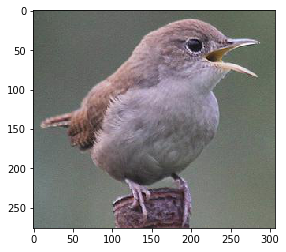

In [24]:
display_image(sample_image)

In [25]:
predict_class(sample_image,net)

[{'class': 'house_wren', 'prob': 94.0},
 {'class': 'wrentit', 'prob': 2.0},
 {'class': 'american_dipper', 'prob': 1.0},
 {'class': 'red-eyed_vireo', 'prob': 1.0},
 {'class': 'white-winged_dove', 'prob': 1.0},
 {'class': 'willet', 'prob': 1.0},
 {'class': 'anhinga', 'prob': 0.0},
 {'class': 'barn_owl', 'prob': 0.0},
 {'class': 'dunlin', 'prob': 0.0},
 {'class': 'hoary_redpoll', 'prob': 0.0},
 {'class': 'loggerhead_shrike', 'prob': 0.0},
 {'class': 'long-tailed_duck', 'prob': 0.0},
 {'class': 'mallard', 'prob': 0.0},
 {'class': 'red-tailed_hawk', 'prob': 0.0},
 {'class': 'snowy_owl', 'prob': 0.0},
 {'class': 'turkey_vulture', 'prob': 0.0}]

In [26]:
file_name = '../models/model_skorch.pkl'


In [27]:
with open(file_name, 'wb') as f:
    pickle.dump(net, f)

In [28]:
with open(file_name, 'rb') as f:
    new_net = pickle.load(f)

In [29]:
predict_class(sample_image,new_net)

[{'class': 'house_wren', 'prob': 94.0},
 {'class': 'wrentit', 'prob': 2.0},
 {'class': 'american_dipper', 'prob': 1.0},
 {'class': 'red-eyed_vireo', 'prob': 1.0},
 {'class': 'white-winged_dove', 'prob': 1.0},
 {'class': 'willet', 'prob': 1.0},
 {'class': 'anhinga', 'prob': 0.0},
 {'class': 'barn_owl', 'prob': 0.0},
 {'class': 'dunlin', 'prob': 0.0},
 {'class': 'hoary_redpoll', 'prob': 0.0},
 {'class': 'loggerhead_shrike', 'prob': 0.0},
 {'class': 'long-tailed_duck', 'prob': 0.0},
 {'class': 'mallard', 'prob': 0.0},
 {'class': 'red-tailed_hawk', 'prob': 0.0},
 {'class': 'snowy_owl', 'prob': 0.0},
 {'class': 'turkey_vulture', 'prob': 0.0}]

In [4]:
from torch import nn, optim
optim = optim.Adam({}, lr=0.0001)

ValueError: optimizer got an empty parameter list

In [2]:
optim.Adam(model.classifier.parameters(), lr=0.0001)

AttributeError: type object 'Adam' has no attribute 'Adam'